In [1]:
import pennylane as qml
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_probabilities(probs):
    """
    Plot probabilities of all qubit combinations as a histogram.
    
    Args:
        probs (torch.Tensor): Probability tensor of length 2^n_qubits
    """
    n_qubits = int(np.log2(len(probs)))
    states = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    
    plt.figure(figsize=(12, 6))
    plt.bar(states, probs.detach().numpy())
    plt.xticks(rotation=45)
    plt.xlabel('Qubit State')
    plt.ylabel('Probability')
    plt.title(f'Probability Distribution over {n_qubits}-Qubit States')
    
    # Add probability values on top of bars
    for i, prob in enumerate(probs):
        plt.text(i, prob.item() + 0.01, f'{prob.item():.3f}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


def plot_qubit_probabilities(probs):
    """
    Plot individual qubit probabilities showing likelihood of 0 and 1 states for each qubit.
    
    Args:
        probs (torch.Tensor): Probability tensor of length 2^n_qubits
    """
    n_qubits = int(np.log2(len(probs)))
    probs_np = probs.detach().numpy()
    
    # Calculate probability of |1⟩ for each qubit
    qubit_probs = np.zeros(n_qubits)
    
    # For each qubit, sum probabilities where that qubit is 1
    for state_idx in range(len(probs)):
        state_str = format(state_idx, f'0{n_qubits}b')
        for qubit_idx in range(n_qubits):
            if state_str[qubit_idx] == '1':
                qubit_probs[qubit_idx] += probs_np[state_idx]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot bars for both 0 and 1 probabilities
    x = np.arange(n_qubits)
    width = 0.35
    
    # Plot probability of |0⟩
    zeros = ax.bar(x - width/2, 1 - qubit_probs, width, label='|0⟩', color='skyblue')
    # Plot probability of |1⟩
    ones = ax.bar(x + width/2, qubit_probs, width, label='|1⟩', color='lightcoral')
    
    ax.set_ylabel('Probability')
    ax.set_title('Individual Qubit State Probabilities')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Qubit {i}' for i in range(n_qubits)])
    ax.legend()
    
    # Add probability labels on the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(zeros)
    autolabel(ones)
    
    plt.tight_layout()
    plt.show()



class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.params = torch.nn.Parameter(torch.randn(5, requires_grad=True))
        print(self.params)
        
        self.dev = qml.device('default.qubit', wires=len(self.params))
        
        @qml.qnode(self.dev, interface='torch')
        def quantum_circuit(params):
            
            for i in range(len(params)): # applies PauliX and Hadamard to all qubits
                qml.PauliX(wires=i)
                qml.Hadamard(wires=i)
            
            for i in range(len(self.params)-1): # itterates through all except last qubit
                qml.CNOT(wires=[i,i+1])
                qml.RY(self.params[i], wires=i+1)
            
            qml.CNOT(wires=[len(self.params)-1, 0]) # handles last qubit
            qml.RY(self.params[-1], wires=0)
            
            
            for i in range(len(params)): # applies Hadamard to all qubits
                qml.Hadamard(wires=i)
                
            return qml.probs()
        
        self.quantum_circuit = quantum_circuit
    
    def forward(self):
        return self.quantum_circuit(self.params)


Parameter containing:
tensor([-1.0104,  1.0772,  0.1949, -1.2033, -0.7284], requires_grad=True)


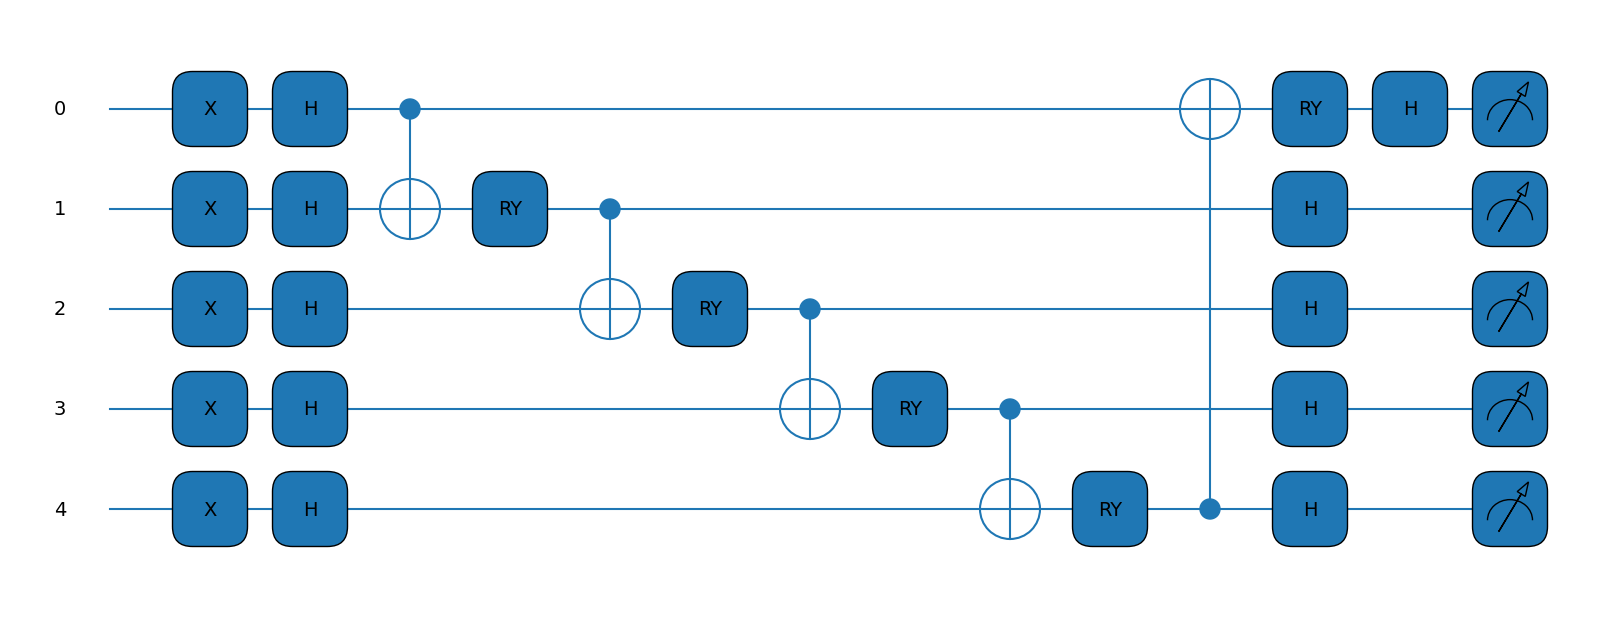

In [2]:
model = QuantumModel()

qml.draw_mpl(model.quantum_circuit, style='default')(model.params)
plt.show()

In [3]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.1)

target_probs = torch.zeros(pow(2,len(model.params)))
target_probs[3] = 0.9 # choose which output state you want to occur with high probability
target_probs = target_probs.requires_grad_(True)


print(f"Number of target values: {len(target_probs)}")
print(f"Target values: {target_probs}")
epochs = 100

for epoch in range(epochs):
    optimiser.zero_grad()
    output = model()    
    loss = torch.mean((output - target_probs)**2) # MSE
    loss.backward()
    optimiser.step()
    
    # if (epoch + 1) % 5 == 0:
        # print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
        # print(f"Parameters: {model.params.data}")
        # print(f"First few outputs: {output[:5].detach()}")
        # print("-" * 50)

print(model.params)        

Number of target values: 32
Target values: tensor([0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], requires_grad=True)
Parameter containing:
tensor([ 0.2745, -0.2633,  3.3998, -0.2213,  0.2763], requires_grad=True)


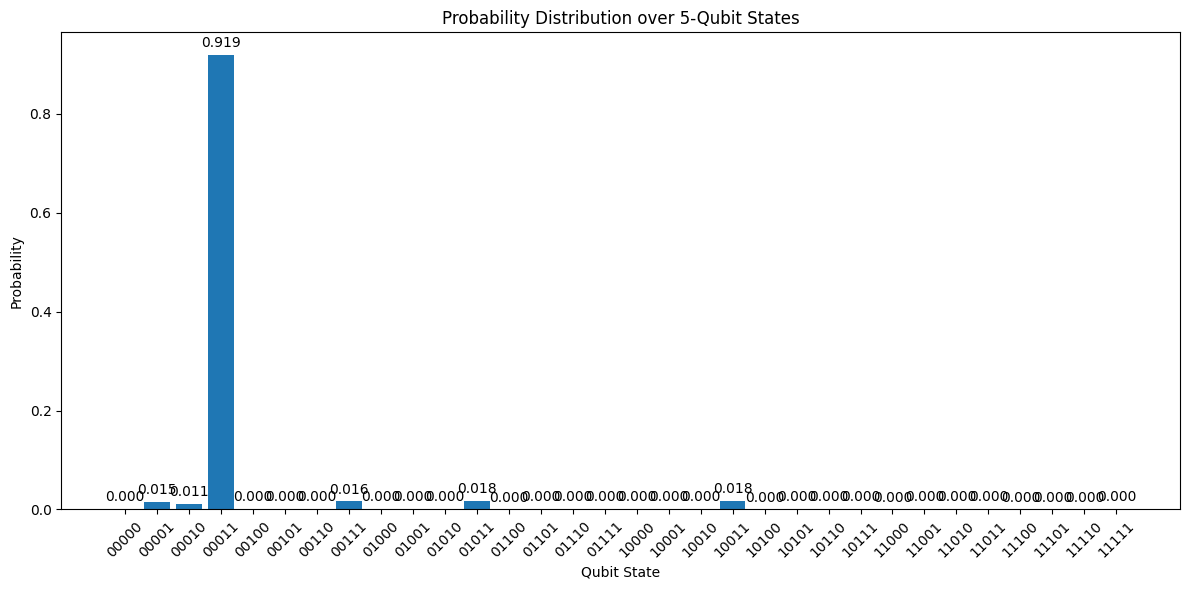

In [4]:
output = model()

plot_probabilities(output)

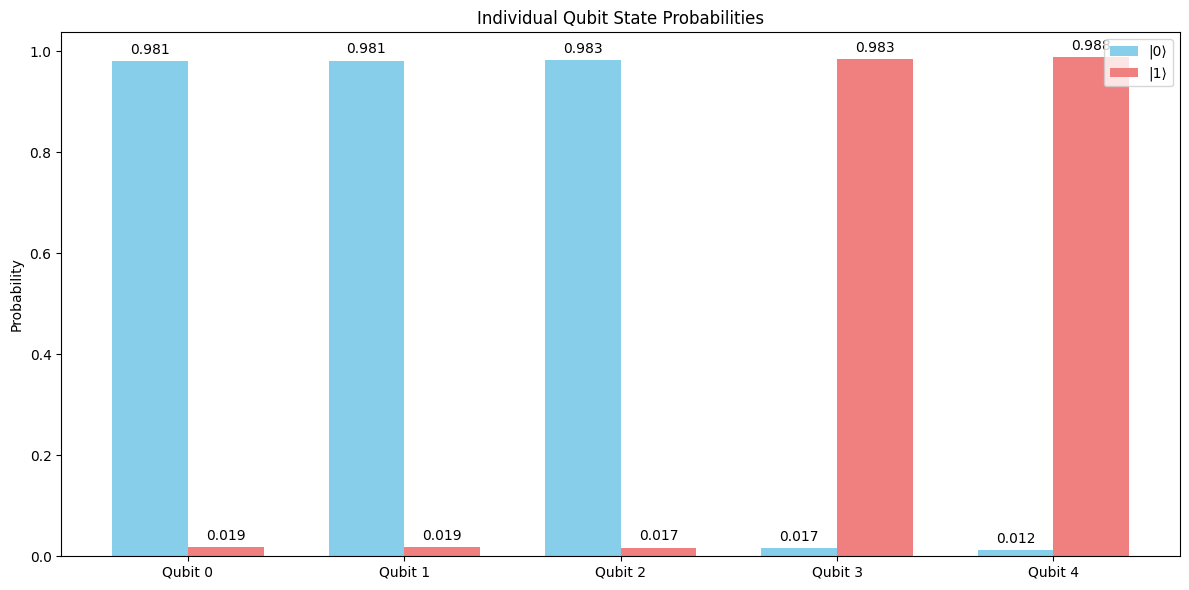

In [5]:
plot_qubit_probabilities(output)